In [1]:
import ROOT
from ROOT import pixevd
import numpy

Welcome to JupyROOT 6.08/06


Get an instance of the dqm file reader:

In [2]:
geom = pixevd.GeoService.GetME()

# override the wire drawing process for lariat
process = pixevd.ReadDQMFile(geom.n_time_ticks())
process.initialize()

In [3]:
_file = "/home/cadams/pixlar-evd/dqm_r014727_sr0002.root"
process.setInput(_file)
process.goToEvent(15)

Attempting to open file /home/cadams/pixlar-evd/dqm_r014727_sr0002.root


Plot the data to make sure we've got an event with some interesting stuff in it:

In [4]:
pixels = process.as_array(0)
pads   = process.as_array(1)

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

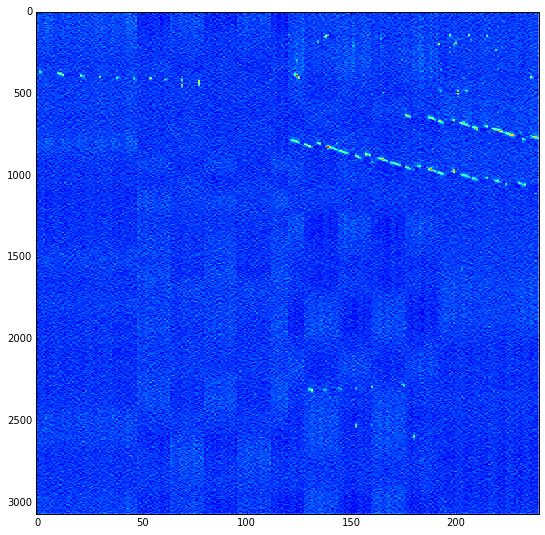

In [6]:
fig = plt.figure(figsize=(16,9))
plt.imshow(pixels.T, interpolation="none", aspect=240./3072)
plt.show()

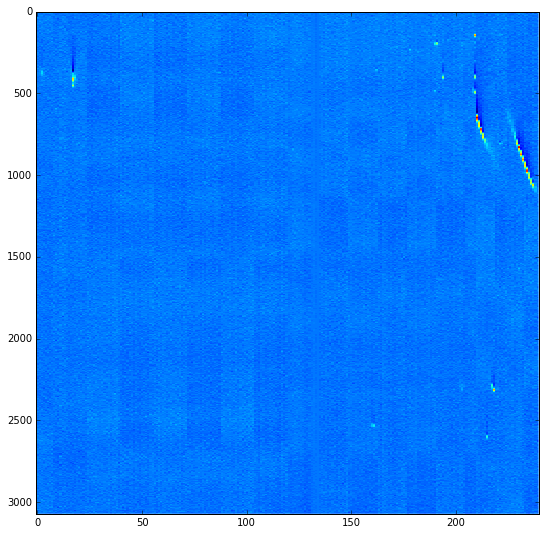

In [7]:
fig = plt.figure(figsize=(16,9))
plt.imshow(-pads.T, interpolation="none", aspect=240./3072)
plt.show()

### Hit finding

Draw a waveform with pixel signals, and try the hit finding algorithms:

In [8]:
pixel_signal = pixels[1]

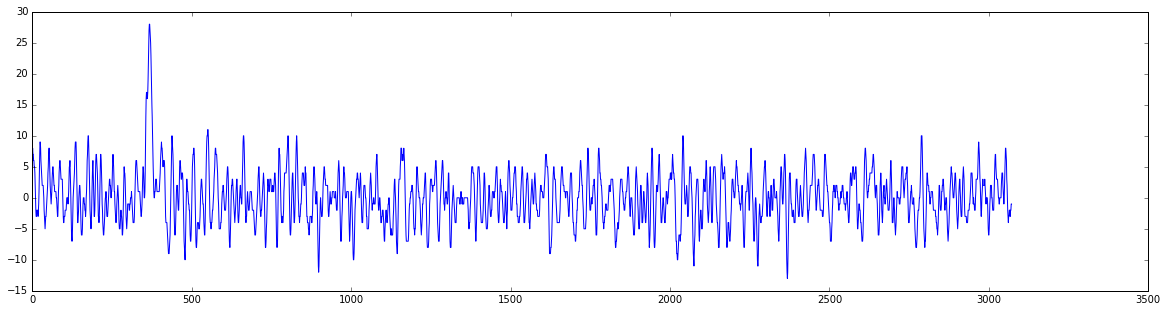

In [9]:
fig = plt.figure(figsize=(20,5))
x = numpy.arange(3072)
plt.plot(x, pixel_signal)
plt.show()

Convert this signal to a root vector just o pass it to the hit finding function (returns a sparse vector)

In [10]:
root_pix_signal = ROOT.vector(float)()
root_pix_signal.resize(3072)
for i, v in enumerate(pixel_signal):
    root_pix_signal[i] = v

In [11]:
utils = pixevd.Utils.GetME()

In [12]:
sparse_pixel = utils.suppressed_waveform(root_pix_signal, 11, 2)

In [13]:
print sparse_pixel

<ROOT.pixevd::ordered_sparse_waveform object at 0x9cee900>


In [14]:
for v in sparse_pixel.as_vector():
    print v.time
    print v.size()
    

356
20


Plot them over the signal above:

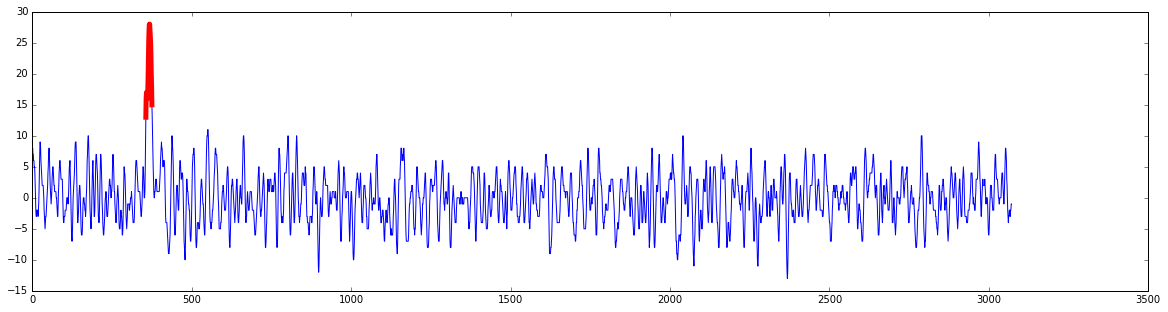

(356, 376)


In [15]:
fig = plt.figure(figsize=(20,5))
x = numpy.arange(3072)
plt.plot(x, pixel_signal)
for v in sparse_pixel.as_vector():
    print "({}, {})".format(v.time, v.time+ v.size())
    if v.size() < 2:
        continue
    x_v = numpy.arange(v.size()) + v.time
    y_v = numpy.zeros((v.size()))
    for i, val in enumerate(v):
        y_v[i] = val
#     y_v = numpy.asarray(v)
    plt.plot(x_v, y_v, lw=5, c='red')
plt.show()

Let's do the same for a pad value:

In [16]:
pad_signal = pads[2]

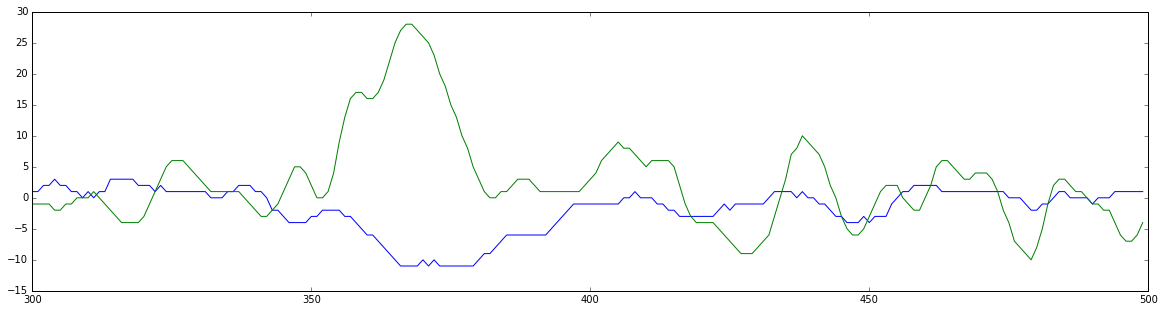

In [17]:
fig = plt.figure(figsize=(20,5))
x = numpy.arange(3072)
plt.plot(x[300:500], pad_signal[300:500])
plt.plot(x[300:500], pixel_signal[300:500])
plt.show()

In [18]:
root_pad_signal = ROOT.vector(float)()
root_pad_signal.resize(3072)
for i, v in enumerate(pad_signal):
    root_pad_signal[i] = v
sparse_pad = utils.suppressed_waveform(root_pad_signal, -10, 3)

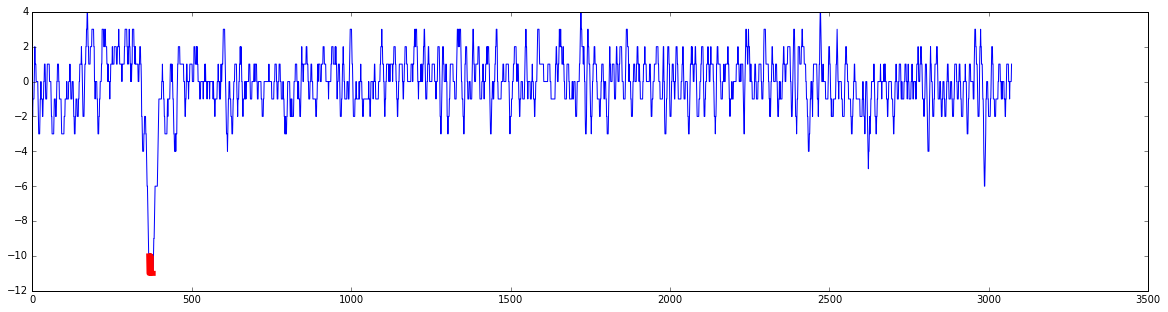

(365, 380)


In [19]:
fig = plt.figure(figsize=(20,5))
x = numpy.arange(3072)
plt.plot(x, pad_signal)
for v in sparse_pad.as_vector():
    print "({}, {})".format(v.time, v.time + v.size())
    if v.size() < 2:
        continue
    x_v = numpy.arange(v.size()) + v.time
    y_v = numpy.zeros((v.size()))
    for i, val in enumerate(v):
        y_v[i] = val
#     y_v = numpy.asarray(v)
    plt.plot(x_v, y_v, lw=5, c='red')
plt.show()

## Pixel/Pad Matching

Hit finding looks good.  So now try to find all hits and match across pixels/pads.  Creating a voxel set on the fly to store the output.

In [20]:
pixel_hits = []
pad_hits = []
temp_signal = ROOT.vector(float)()
temp_signal.resize(3072)
for pixel_waveform in pixels:
    for i, v in enumerate(pixel_waveform):
        temp_signal[i] = v
    pixel_hits.append(utils.suppressed_waveform(temp_signal, 11, 2))
for pad_waveform in pads:
    for i, v in enumerate(pad_waveform):
        temp_signal[i] = v
    pad_hits.append(utils.suppressed_waveform(temp_signal, -10, 3))
print len(pixel_hits)
print len(pad_hits)

240
240


In [21]:
# Now we make matches.  First set up a voxel meta and voxel storage

In [22]:
voxel_meta = pixevd.Voxel3DMeta()
xmin = 0.
xmax = 47.
ymin = -20.
ymax = 20.
zmin = 0.
zmax = 90.
xnum = int((xmax - xmin) / 0.05)
ynum = int((ymax - ymin) / 0.3)
znum = int((zmax - zmin) / 0.3)
voxel_meta.set(xmin, ymin, zmin, xmax, ymax, zmax, xnum, ynum, znum)

In [23]:
voxel_set = pixevd.SparseTensor3D()
voxel_set.meta(voxel_meta)

In [24]:
# Now, loop over every sparse waveform and compare hits to compatible pads.  
# If the Intersection over union of the waveforms is above threshold, make voxels out of the two waveforms.
# Assuming the drift velocity is 1.51 mm/microsecond, and 128 ns/timetick, that means 0.19328 mm /timetick
# For the display, we're gonna call it 0.2 mm/timetick

In [32]:
IoU_threshold = 0.2
prespill_ticks = 320
for i_pixel, pixel_hit in enumerate(pixel_hits):
    for i_pad, pad_hit in enumerate(pad_hits):
        # Check for compatibility
        if not geom.compatible(i_pixel, i_pad):
#             print "NC"
            continue
        # Now check every chunk of each sparse vector for overlap
        for pixel_region in pixel_hit.as_vector():
            for pad_region in pad_hit.as_vector():
                    
                intersection = min(pixel_region.time + pixel_region.size(), 
                                   pad_region.time + pad_region.size()) - max(pixel_region.time, 
                                                                              pad_region.time)
                
                if i_pixel == 1 and i_pad == 2:
                    print "I: {}".format(intersection)
                    print "U: {}".format(pixel_region.size() + pad_region.size() - intersection)
                    print "IoU: {}".format(1.*intersection / (pixel_region.size() + pad_region.size() - intersection))
                if intersection <= 0:
                    continue
                
                
                if 1.0*intersection / (pixel_region.size() + pad_region.size() - intersection) > IoU_threshold:
#                     print "Making a voxel"
                    # Make a voxel:
                    # Get the XY coordinates of this pixel/pad combo:
                    xy = geom.xy(i_pixel, i_pad)
                    # Use just the pixel timing for creation of voxels
                    for offset in xrange(pixel_region.size()):
#                         print "Putting a voxel at ({}, {}, {})".format(0.02*(pixel_region.time + offset), xy.x, xy.y)
                        voxel_set.emplace(0.02* (pixel_region.time + offset), xy.y, xy.x, pixel_region[offset])

I: 11
U: 24
IoU: 0.458333333333


In [33]:
print voxel_set.as_vector().size()

133


In [34]:
x = numpy.zeros((voxel_set.as_vector().size()))
y = numpy.zeros((voxel_set.as_vector().size()))
z = numpy.zeros((voxel_set.as_vector().size()))
for i, vox in enumerate(voxel_set.as_vector()):
    x[i] = voxel_meta.pos_x(vox.id())
    y[i] = voxel_meta.pos_y(vox.id())    
    z[i] = voxel_meta.pos_z(vox.id())    

Plot 3 projections:

In [35]:
from mpl_toolkits.mplot3d import Axes3D

XY projection:

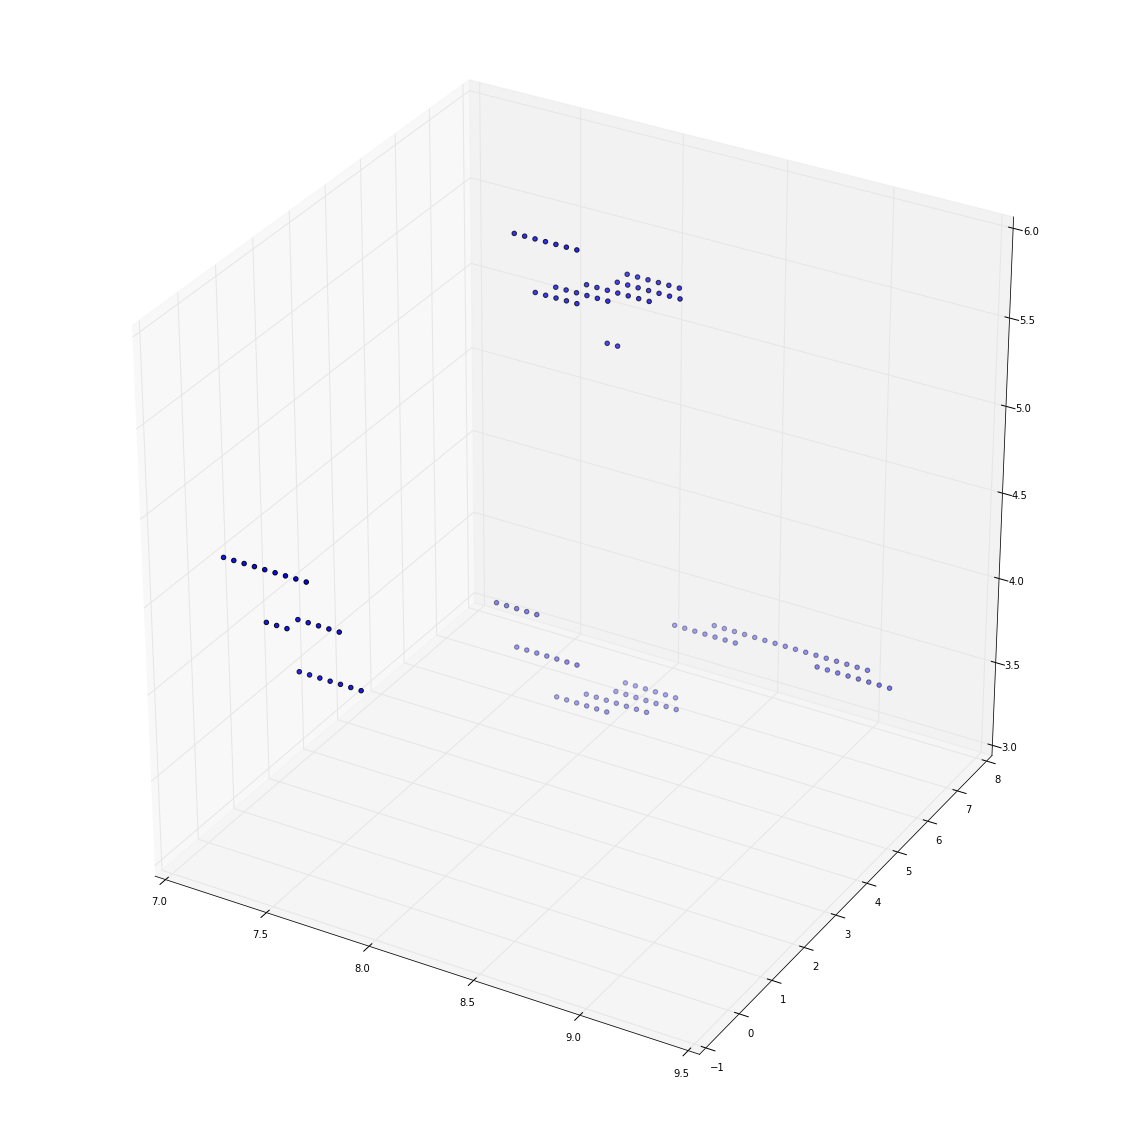

In [37]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()